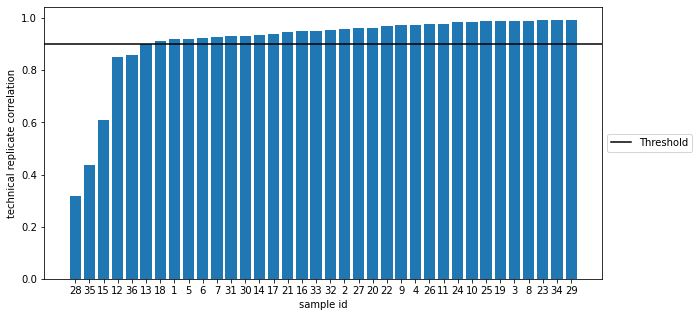

In [40]:
from phip_data import *
%matplotlib inline

# Set some constants
DD = "../empirical_data"
COUNTS = "sample_peptide_counts.csv"
PMETA= "peptide_metadata.csv"
SMETA= "sample_metadata.csv"
OUTDIR="./fold_analysis_output"

out_dir = os.path.join(DD,OUTDIR)
raw_counts = os.path.join(DD,COUNTS)
peptide_metadata = os.path.join(DD,PMETA)
sample_metadata = os.path.join(DD,SMETA)
# TODO extract this from sample metadata.
beads_only = "35"
corr_thresh = 0.9

if not os.path.exists(out_dir): os.mkdir(out_dir) 

# TODO just make a function which returns all raw_counts and metadata 
# after error checking the input
raw_counts = pd.read_csv(raw_counts, header=0, index_col=0)
peptide_metadata = pd.read_csv(peptide_metadata, header=0, index_col=0)
sample_metadata = pd.read_csv(sample_metadata, header=0, index_col=0)

# Make sure we have the same indexing going on here.
assert(set(raw_counts.index) == set(peptide_metadata.index))

# Now we need to look at correlation between the technical replicates
library_control, technical_rep_1, technical_rep_2 = extract_sample_info(raw_counts)
correlations, samples = prune_non_correlated_replicate_samples(
    raw_counts, 
    technical_rep_1,
    technical_rep_2)

fig, ax = plt.subplots(figsize=(13, 10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

correlations = [c[0] for c in correlations]
samples = [x for _,x in sorted(zip(correlations,samples))]
ax.bar(samples, sorted(correlations))
ax.axhline(y=corr_thresh, color="black", label = "Threshold")
ax.set_ylabel(f"technical replicate correlation")
ax.set_xlabel(f"sample id")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(10,5)
#fig.savefig(os.path.join(out_dir,"technical_replicates_correlation.pdf"))
plt.show()

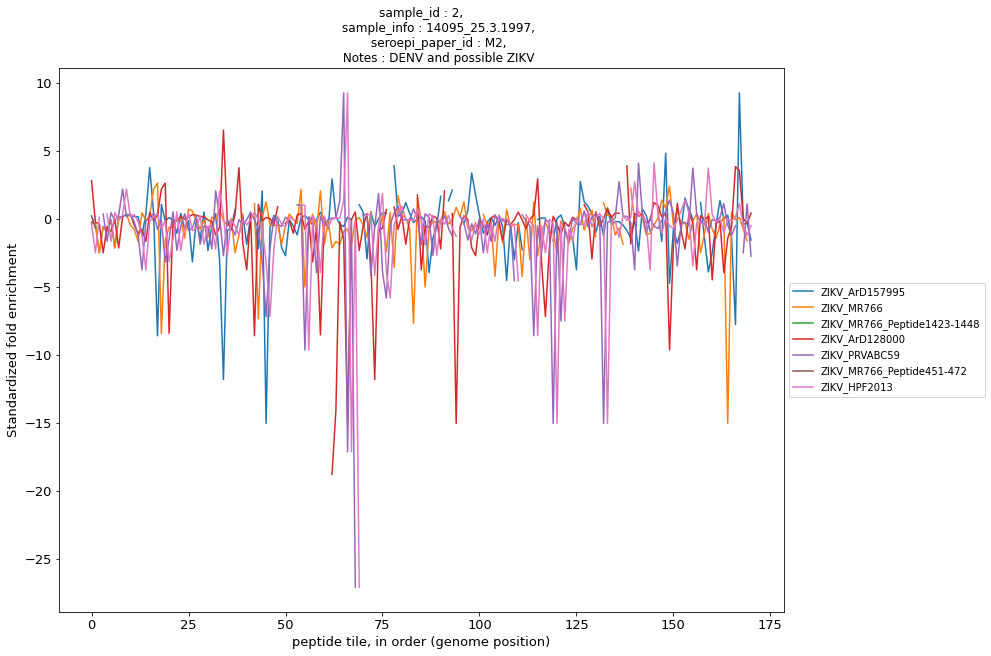

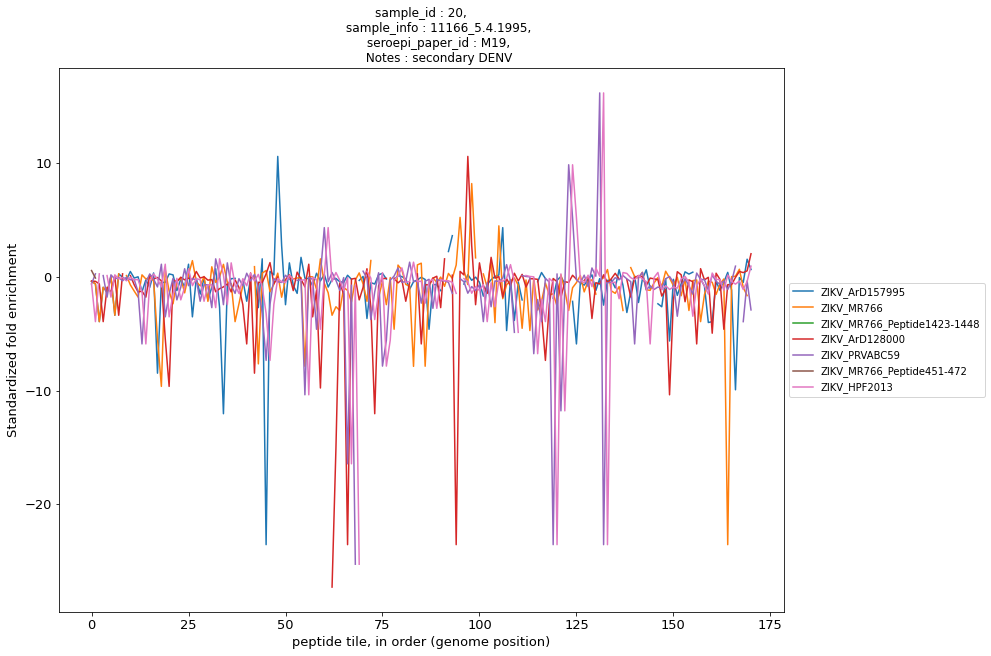

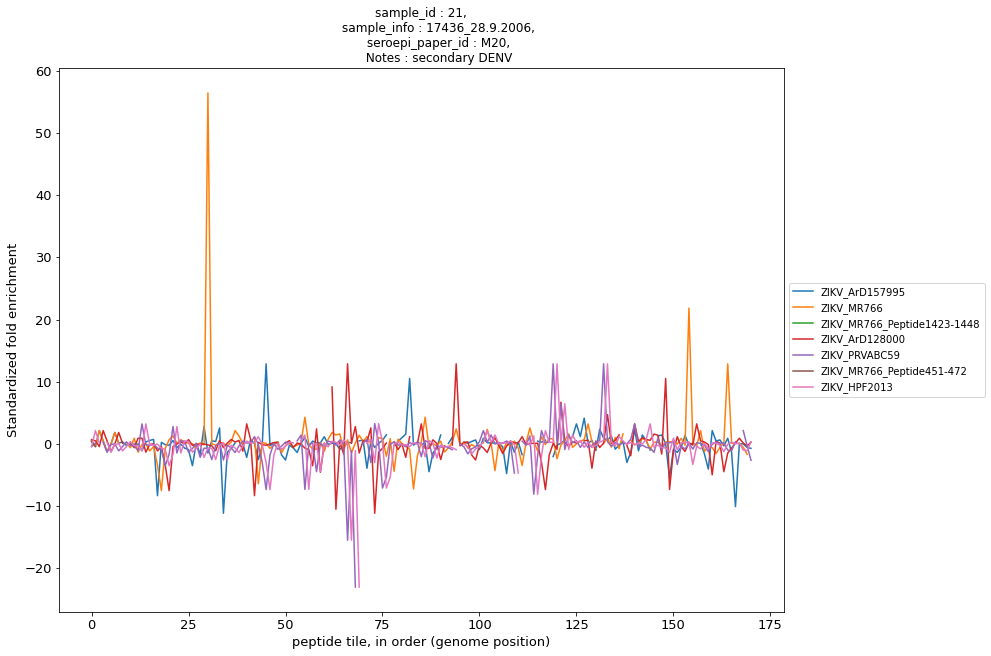

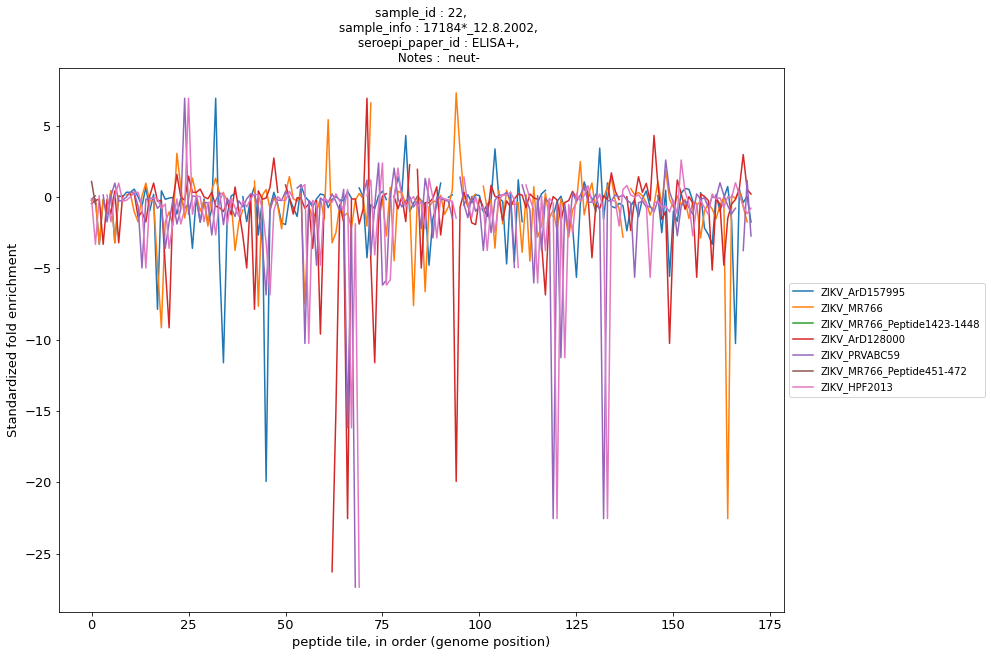

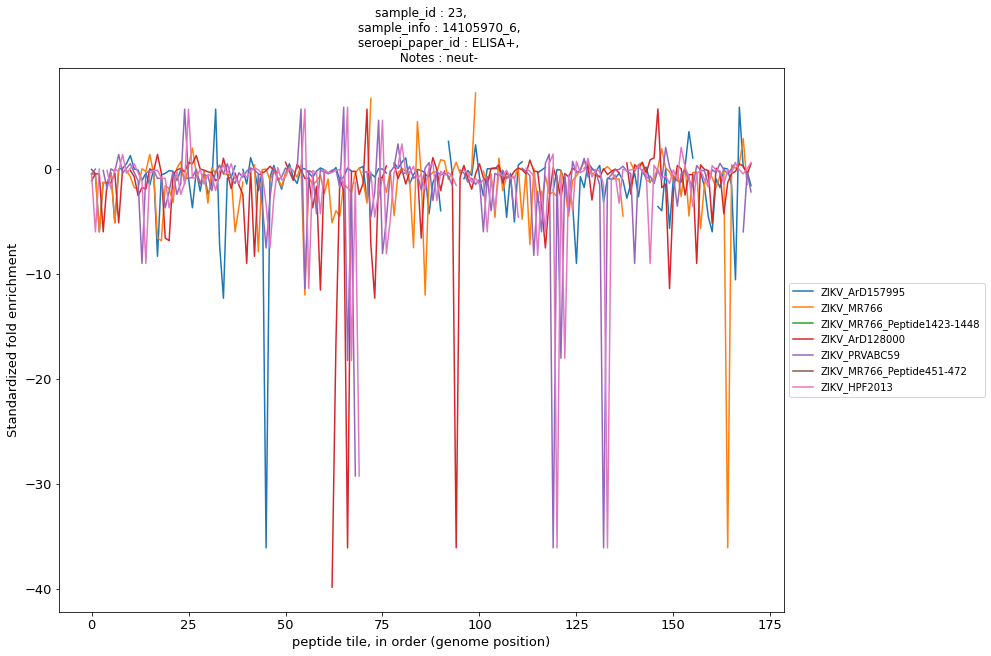

In [54]:
standardized_enrichment = get_standardized_enrichment(raw_counts)

#strain_pattern = "HIV.+"
#strain_pattern = "DENV.+"
strain_pattern = "ZIKV.+"

# samples to look at, this could also be done 
# by querying the sample metadata
samples = standardized_enrichment.columns[9:14]

all_strains = set(peptide_metadata["Virus_Strain"])
selected_strains = [re.match(strain_pattern,f"{strain}")[0] 
    for strain in all_strains 
    if re.match(strain_pattern,f"{strain}") != None]

for sample in samples:
    if sample == library_control: continue
    
    fig, ax = plt.subplots(figsize=(13, 10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    
    for strain in selected_strains:
        strain_index = peptide_metadata[peptide_metadata["Virus_Strain"] == strain].index
        ax.plot(list(range(len(strain_index))),
                standardized_enrichment[sample][strain_index],
                label = strain)
    
    # TODO : we should make these string, or the the 
    # header for counts data integers ... ?
    sample = int(sample)
    
    sample_info = sample_metadata["sample_info"][sample]
    seroepi_paper_id = sample_metadata["seroepi_paper_id"][sample]
    notes = sample_metadata["Notes"][sample]
    ax.set_title(
        f"sample_id : {sample},\n \
        sample_info : {sample_info},\n \
        seroepi_paper_id : {seroepi_paper_id},\n \
        Notes : {notes}")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(f"Standardized fold enrichment")
    ax.set_xlabel(f"peptide tile, in order (genome position)")
    plt.show()

